In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
import numpy as np
from time import time

In [2]:
def get_datasets(name):
    if name == "rcv1":
        X_train, y_train = load_svmlight_file(f"data/{data_name}_train")
        X_test, y_test = load_svmlight_file(f"data/{data_name}_test")
        return X_train, X_test, y_train, y_test
    else:
        X, y = load_svmlight_file(f"data/{name}.binary")
        return train_test_split(X, y, random_state=123, train_size=0.6)
        

def accuracy_score_svm(w, X, y):
    return np.mean(((w @ X.T > 0) * 2 - 1) == y)

def calculate_data(param, X_train, y_train, X_test, y_test):
    from sklearn.svm import LinearSVC
    m_ref = LinearSVC(C=1, tol=1e-12, fit_intercept=False, max_iter=5000, dual=False)
    m_ref.fit(X_train, y_train)
    
    from Algorithm import CoordinateDescent
    cd = CoordinateDescent(ro=param, C=1., eps=1e-3)
    w = cd.fit_process(X_train, y_train)
    
    dist_hist = [
        np.linalg.norm(m_ref.coef_.reshape(-1) - el[0], ord=2) for el in cd.history
    ]
    
    acc_hist = [
        accuracy_score_svm(el[0], X_test, y_test) for el in cd.history
    ]
    
    return np.array([el[2] for el in cd.history]) - cd.history[0][2], dist_hist, acc_hist

In [3]:
param_space = [0.01, 0.05, 0.1, 0.25]
data_space = ["rcv1", "news20", "real-sim"]
results = {}

In [4]:
for data_name in data_space:
    X_train, X_test, y_train, y_test = get_datasets(data_name)
    results[data_name] = {}
    for param in param_space:
        if param not in results[data_name]:
            print(f"{data_name} C = {param:.0f}", end="\r")
            times, dists, accs = calculate_data(param, X_train, y_train, X_test, y_test)
            results[data_name][param] = {
                "times": times,
                "dists": dists,
                "accs": accs
            }

In [5]:
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


with open("c_influence.json", "w") as f:
    json.dump(results, f, cls=NumpyEncoder)

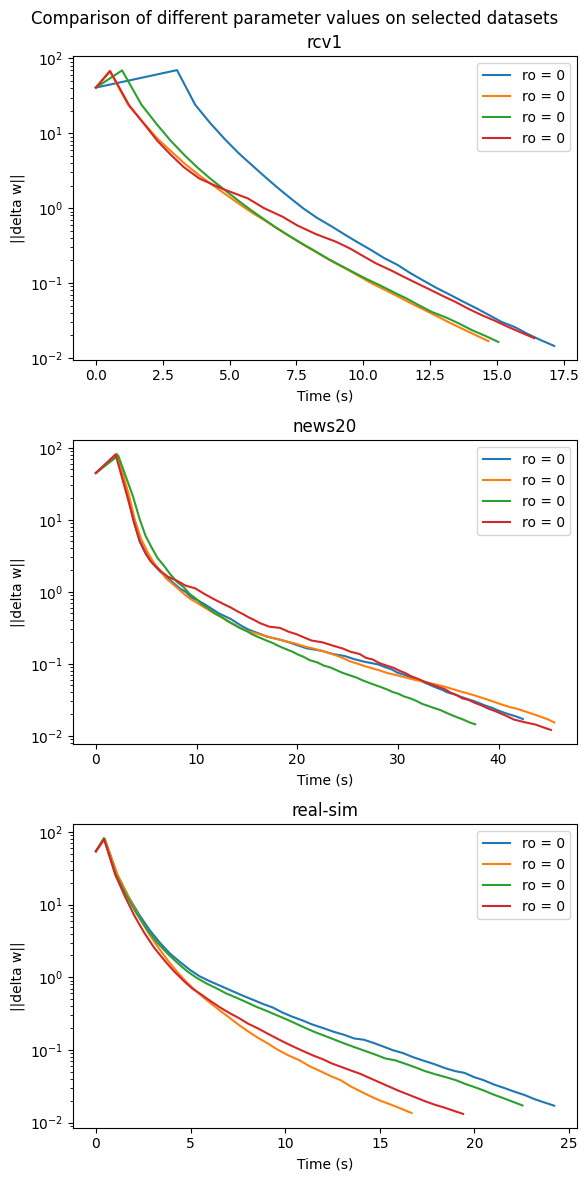

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(data_space))
fig.suptitle("Comparison of different parameter values on selected datasets")
for ax, data_name in zip(axs, data_space):
    for param in param_space:
        res = results[data_name][param]
        ax.plot(res["times"], res["dists"])
        ax.set_title(f"{data_name}")
    ax.legend([f"ro = {param:.0f}" for param in param_space])
    ax.set_yscale("log")
    ax.set_ylabel("||delta w||")
    ax.set_xlabel("Time (s)")
fig.set_size_inches(6, 12)
plt.tight_layout()